In [53]:
# data manipulation and visulization
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
import torchvision
from torchvision import transforms
from torch import nn

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [55]:
train_transform = transforms.Compose(
    [
        transforms.Resize((64,64)),
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        
    ]
)

test_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
        
    ]
)


In [56]:
from torch.utils.data import DataLoader

trainset = torchvision.datasets.FashionMNIST(root = "./",
                                             train = True,
                                             download = False,
                                             transform= train_transform)
testset = torchvision.datasets.FashionMNIST(root= "./",
                                            train = False, 
                                            download = False,
                                            transform= test_transform)

train_dataloader = DataLoader(dataset= trainset,
                              batch_size= 32,
                              num_workers= 0,
                              shuffle= True)

test_dataloader = DataLoader(dataset= testset,
                             batch_size= 32,
                             num_workers= 0,
                             shuffle= True)

In [77]:
trainset[0][0].shape

torch.Size([1, 64, 64])

In [88]:
import torch
import torch.nn as nn

class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super(TinyVGG, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces height and width by 2
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces height and width by 2
        )

        # Calculate the size of the feature map after the convolutional layers
        self.feature_map_size = hidden_units * 7 * 7  # 7x7 after two MaxPool2d layers with stride 2

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=self.feature_map_size, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


In [89]:
model = TinyVGG(input_shape = 1,
              hidden_units = 64, 
              output_shape = len(trainset.classes)).to(device)

from torchinfo import summary
print("VGG-16 Summary:","\n",summary(model),"\n")


VGG-16 Summary: 
Layer (type:depth-idx)                   Param #
TinyVGG                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       640
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       36,928
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       36,928
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Flatten: 2-11                     --
│    └─Linear: 2-12                      31,370
Total params: 142,794
Trainable params: 142,794
Non-trainable params: 0



In [90]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (x,y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        y_pred = model(x)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim =1), dim = 1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred_class)


    # avg train loss and acc
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

def test_step(model: torch.nn.Module,
            dataloader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module):
    
    model.eval()

    test_loss, test_acc = 0,0

    with torch.inference_mode():
        for batch, (x,y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            test_y_pred = model(x)

            loss = loss_fn(test_y_pred, y)
            test_loss += loss

            test_y_pred_class = torch.argmax(torch.softmax(test_y_pred, dim = 1), dim = 1)
            test_acc += (test_y_pred_class == y).sum().item() / len(test_y_pred_class)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc
    

In [91]:
# from tqdm import tqdm 
# start  the timer 
from timeit import default_timer as timer 

def train(model:nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int = 50):
    
    # create an empty results dir
    results = {"train_loss":[],
               "test_loss":[],
               "train_acc":[],
               "test_acc":[]}
    
    # loop for training an testing
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model = model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer = optimizer)

        test_loss, test_acc = test_step(model = model,
                                        dataloader = test_dataloader,
                                        loss_fn = loss_fn)

        
        print(
            f"epochs: {epoch+1} | train_loss: {train_loss} | train_acc: {train_acc} | test_loss: {test_loss} | test_acc: {test_acc}"
            )
        
        # update the results dictionary
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    return results

In [92]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

num_epochs = 5

loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)
optimizer = {
    "SGD": lambda params: torch.optim.SGD(params, lr = 0.001),
    "RMSprop": lambda params: torch.optim.RMSprop(params, lr = 0.001),
    "Adam": lambda params: torch.optim.Adam(params, lr = 0.001),
    "Adagrad": lambda params: torch.optim.Adagrad(params, lr = 0.001),
    "AdaDelta": lambda params: torch.optim.Adadelta(params, lr = 0.001)
}

start_time = timer()

opt_results = {}
for opt_name, opt_func in optimizer.items():
    print(f"Training with {opt_name}...")

    model_reults = train(model = model,
                        train_dataloader= train_dataloader,
                        test_dataloader= test_dataloader,
                        loss_fn= loss_fn,
                        optimizer= opt_func(model.parameters()),
                        epochs= num_epochs)
    opt_results[opt_name] = model_reults

end_time = timer()

print(f"total training time: {end_time - start_time:.3f} seconds")

# Step 5: Visualize Results
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
for opt_name, result in opt_results.items():
    plt.plot(result['train_loss'], label=f"{opt_name} Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot test accuracy
plt.subplot(1, 2, 2)
for opt_name, result in opt_results.items():
    plt.plot(result['test_accuracy'], label=f"{opt_name} Accuracy")
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

# Print runtimes
for opt_name, result in opt_results.items():
    print(f"{opt_name} Runtime: {result['runtime']:.2f} seconds")

Training with SGD...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x16384 and 3136x10)

TypeError: Input z must be 2D, not 1D

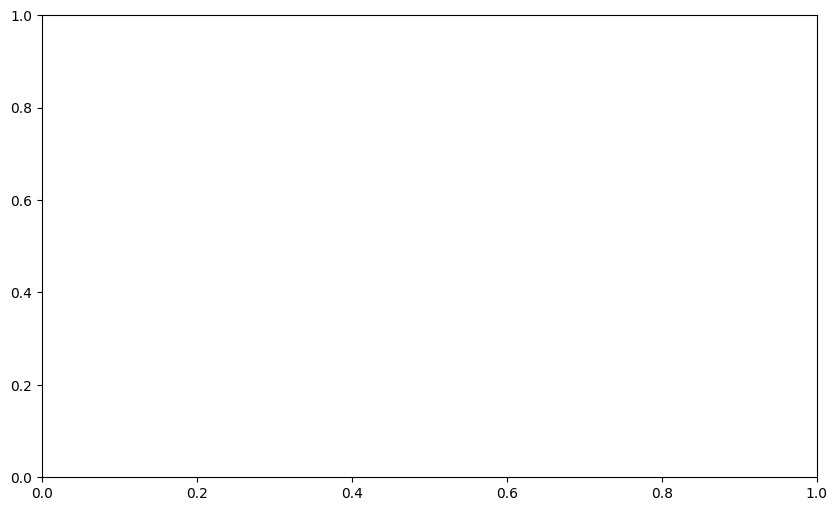

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Prepare data for contour plot
optimizers = list(opt_results.keys())
epochs = list(range(1, num_epochs + 1))
# Create a 2D array of losses
loss_matrix = np.array([opt_results[opt_name]['train_loss'] for opt_name in optimizers])

# Create a contour plot
plt.figure(figsize=(10, 6))
X, Y = np.meshgrid(epochs, range(len(optimizers)))  # Grid for epochs and optimizers
Z = loss_matrix

# Plot the contour map
contour = plt.contourf(X, Y, Z, cmap='viridis', levels=20)
plt.colorbar(contour)

# Add labels
plt.title("Training Loss Contour Map")
plt.xlabel("Epoch")
plt.ylabel("Optimizer")
plt.yticks(range(len(optimizers)), optimizers)
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()
